In [1]:
import itertools
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def oriented_bounding_box(points):
    p_mean = points.mean(axis=0)
    points -= p_mean
    cov = np.cov(points.T)
    w, v = np.linalg.eig(cov)
    
    ax_min_max = []
    for i in range(points.shape[1]):        
        vi = v[:, i]
        pi = points.dot(vi)
        ax_min_max.append([pi.min(), pi.max()])
    
    vertices = []
    for vertex in itertools.product(*ax_min_max):
        vertices.append(vertex)
    
    vertices = np.array(vertices)
    vertices = vertices.T
    vertices = v.dot(vertices)
    vertices += p_mean[:,np.newaxis]
    
    points += p_mean
    return vertices.T

In [3]:
def oriented_bounding_box_2d_bf(points):
    
    area = float('inf')
    
    #e_x, e_y, px_min, px_max, py_min, py_max
    for theta in np.arange(0, 0.5*np.pi, np.pi/180):
        new_e_x = np.array([np.cos(theta), np.sin(theta)])
        new_e_y = np.array([-np.sin(theta), np.cos(theta)])
        
        px = points.dot(new_e_x)
        py = points.dot(new_e_y)
        
        new_px_min = px.min()
        new_px_max = px.max()
        new_py_min = py.min()
        new_py_max = py.max()
        new_area = abs(new_px_max - new_px_min) * abs(new_py_max - new_py_min)
        
        if new_area < area:
            e_x = new_e_x
            e_y = new_e_y
            px_min = new_px_min
            px_max = new_px_max
            py_min = new_py_min
            py_max = new_py_max
            area = new_area
    
    ax_min_max = [[px_min, px_max], [py_min, py_max]]
    
    vertices = []
    for vertex in itertools.product(*ax_min_max):
        vertices.append(vertex)
    
    vertices = np.array(vertices)
    vertices = vertices.T
    vertices = np.array([e_x, e_y]).T.dot(vertices)
    
    return vertices.T

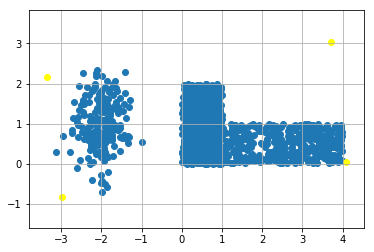

In [27]:
points = np.random.multivariate_normal(np.array([-2,1]), np.diag([0.1,0.4]), 200)
d1 = np.random.uniform(0.0, 1.0, size=(500, 2))
d1[:,0] *= 4
d2 = np.random.uniform(0.0, 1.0, size=(500, 2))
d2[:,1] *= 2
points = np.concatenate((points, d1, d2))

p1, p2, p3, p4 = oriented_bounding_box_2d_bf(points)

plt.scatter(points[:,0], points[:,1])
#plt.xlim(-0.5, 1.5)
#plt.ylim(-0.5, 1.5)
plt.axis('equal')
plt.grid()

plt.scatter(p1[0], p1[1], c='yellow')
plt.scatter(p2[0], p2[1], c='yellow')
plt.scatter(p3[0], p3[1], c='yellow')
plt.scatter(p4[0], p4[1], c='yellow')

In [5]:
points = np.random.multivariate_normal(np.zeros(3), np.diag([100,50,10]), 20)
points = np.random.uniform(size=(20, 3))

p_min, p_max = oriented_bounding_box(points)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], alpha=0.1)

lines = []

diff = p_max - p_min
dx = diff[0]
dy = diff[1]
dz = diff[2]

px = p_min[0]
py = p_min[1]
pz = p_min[2]

lines.append(np.array([[px,py,pz], [px+dx,py,pz]]))
lines.append(np.array([[px,py,pz], [px,py+dy,pz]]))
lines.append(np.array([[px,py,pz], [px,py,pz+dz]]))

lines.append(np.array([[px+dx,py,pz+dz], [px+dx,py,pz]]))
lines.append(np.array([[px+dx,py,pz+dz], [px,py,pz+dz]]))
lines.append(np.array([[px+dx,py,pz+dz], [px+dx,py+dy,pz+dz]]))

lines.append(np.array([[px,py+dy,pz+dz], [px,py,pz+dz]]))
lines.append(np.array([[px,py+dy,pz+dz], [px,py+dy,pz]]))
lines.append(np.array([[px,py+dy,pz+dz], [px+dx,py+dy,pz+dz]]))

lines.append(np.array([[px+dx,py+dy,pz], [px,py+dy,pz]]))
lines.append(np.array([[px+dx,py+dy,pz], [px+dx,py,pz]]))
lines.append(np.array([[px+dx,py+dy,pz], [px+dx,py+dy,pz+dz]]))

for l in lines:
    ax.plot([l[0][0], l[1][0]],
            [l[0][1], l[1][1]],
            [l[0][2], l[1][2]])
    
ax.scatter(p_min[0], p_min[1], p_min[2])
ax.scatter(p_max[0], p_max[1], p_max[2])
#ax.plot([p_min[0], p_max[0]], [p_min[1], p_max[1]], [p_min[2], p_max[2]])

ValueError: too many values to unpack (expected 2)